# Inférence de la variable DCO à partir des données de MRV (Stratégie ML 2)
La variable DCO représente le nom des dispositifs.Il y en a 1500 de différents et notre objectif est d'identifier le dispositif impliqué dans l'incident à partir de deux variables:
- DESCRIPTION DE L'INCIDENT
- LIBELLE COMMERCIAL

A partir des expériences menées dans les notebook stratégie 1 et 1.1, nous avons identifier  les pistes qui fonctionnent:
* Cosntruire des tfidf différents pour les deux variables : DESCRIPTION et LIBELLE
* Utiliser les bigrammes et trigrammes simplement sur les LIBELLE COMMERCIAUX
* Un valeure de C élevé du SVM pénalise l'accuracy mais favorise légerement la  ballanced accuracy


et celles qui marchent moins :
* La lemmatisation
* Les embeddings (fasttext)
* Les bloom embeddings (spacy)



**Stratégie ML 2**
Dans ce problème de classification de texte multiclasse, le pipeline sera le suivant :
1. Nettoyer les données textuelles 
2. Nettoyage des observations (Traitement des doublons au moment de la séparation du train et du test)
3. Construction des features textuelles (Deux tfidf)
4. Entrainement de l'algorithme de classification (SVM probabilisé)
5. Evaluation du modèle (Accuracy, Balanced Accuracy, F1-weighted)


## 0) Chargement des librairies

In [1]:
import warnings
warnings.filterwarnings('ignore')

from pprint import pprint
from time import time
import logging

import pandas as pd

import numpy as np
import sklearn as sk
import seaborn as sns

import nltk
from nltk import word_tokenize
lang ='french'

import clean_text





import matplotlib.pyplot as plt


from sklearn.feature_extraction.text import TfidfVectorizer,HashingVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score,f1_score
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import TruncatedSVD,IncrementalPCA,SparsePCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.calibration import CalibratedClassifierCV

import spacy
nlp =spacy.load('fr')
from spacy.lang.fr.stop_words import STOP_WORDS

## 1) Chargement des données et constructions du jeux d'évaluation
On met de coté environ 20% du dataset pour l'évaluation et on ne garde pour l'entrainement seulement les classes avec plus de 10 observations

In [2]:
%%time
df_declaration_mrv = pd.read_csv("data/data_mrv/declaration_mrv_complet.csv")#delimiter=';',encoding='ISO-8859-1')
id_to_dco = pd.read_csv("data/ref_MRV/referentiel_dispositif.csv",delimiter=';',encoding='ISO-8859-1')

#Charegement des colonnes utiles
df = df_declaration_mrv[['DESCRIPTION_INCIDENT','TYPE_VIGILANCE','LIBELLE_COMMERCIAL',
                         'REFERENCE_COMMERCIALE','ETAT_PATIENT','FABRICANT','DCO_ID','CLASSIFICATION']]
# On complète les NaN avec du vide
df['ETAT_PATIENT'] = df['ETAT_PATIENT'].fillna("")
df['DESCRIPTION_INCIDENT'] = df['DESCRIPTION_INCIDENT'].fillna("")
df['LIBELLE_COMMERCIAL'] = df['LIBELLE_COMMERCIAL'].fillna("")
df['FABRICANT'] = df['FABRICANT'].fillna("")
df["REFERENCE_COMMERCIALE"] = df['REFERENCE_COMMERCIALE'].fillna("")
df['TYPE_VIGILANCE'] = df['TYPE_VIGILANCE'].fillna("")
df['CLASSIFICATION'] = df['CLASSIFICATION'].fillna('')


# On ajoute des collones pertinentes
df['des_lib'] = df['LIBELLE_COMMERCIAL']+ ' ' + df['DESCRIPTION_INCIDENT']
df['fab_lib'] = df['LIBELLE_COMMERCIAL']+ ' ' + df['FABRICANT']
df['com'] = df['LIBELLE_COMMERCIAL']+ ' ' + df['REFERENCE_COMMERCIALE']
df['Text'] = df['LIBELLE_COMMERCIAL']+ ' ' + df['FABRICANT'] + "" + df['DESCRIPTION_INCIDENT']

# On nettoie les données :
for col in  ['DESCRIPTION_INCIDENT','LIBELLE_COMMERCIAL','ETAT_PATIENT','Text',"des_lib","fab_lib"] :
    df[col] = df[col].map(lambda x: clean_text.preprocess_text(x))

n = 15
# On filtre pour a voir plus de n observations par classse
df_n = df.groupby("DCO_ID").filter(lambda x: len(x) > n)

# On encode les labels
le = LabelEncoder()
df_n.DCO_ID = le.fit_transform(df_n.DCO_ID.values)
#On encode le type de vigilance
df_n.TYPE_VIGILANCE = le.fit_transform(df_n.TYPE_VIGILANCE.values)
#On encode la classifcation 
df_n.CLASSIFICATION = le.fit_transform(df_n.CLASSIFICATION.values)

# On selection les variables de test en faisant attention aux doublons
train_index,test_index = next(GroupShuffleSplit(random_state=1029).split(df_n, groups=df_n['DESCRIPTION_INCIDENT']))
df_train, df_test = df_n.iloc[train_index], df_n.iloc[test_index]



CPU times: user 40.4 s, sys: 0 ns, total: 40.4 s
Wall time: 40.4 s


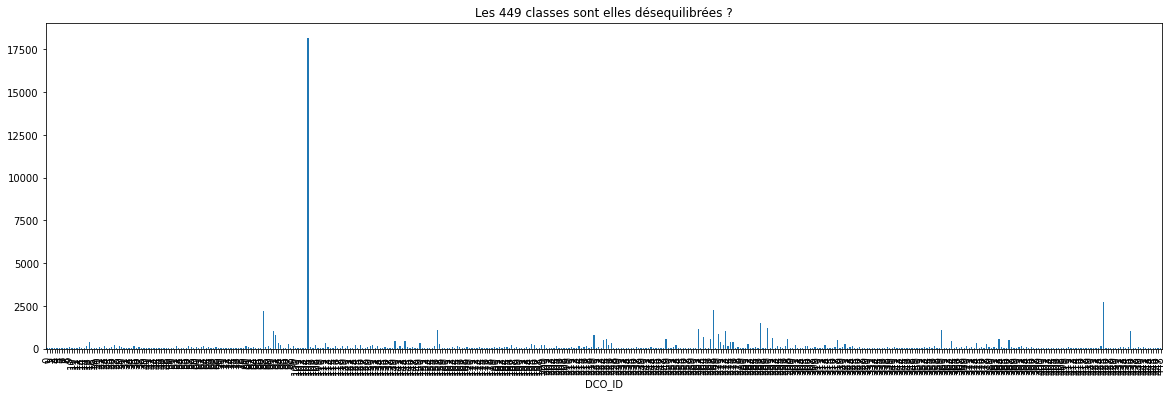

In [12]:
df_n.groupby('DCO_ID').count()['Text'].plot(kind ='bar',figsize=(20,6))
plt.title("Les "+ str(len(df_n['DCO_ID'].unique())) +" classes sont elles désequilibrées ?")
plt.show()

## 2) Construction du pipeline  pour mesurer l'influence du paramètre C

In [5]:
%%time
#Pipeline
preprocess = ColumnTransformer(
    [('libelle_tfidf', TfidfVectorizer(sublinear_tf=True, min_df=3,ngram_range=(1, 3),
                                       stop_words=STOP_WORDS,
                                       max_features = 15000,norm = 'l2'), 'LIBELLE_COMMERCIAL'),
     
     ('description_tfidf',TfidfVectorizer(sublinear_tf=True, min_df=5,
                            ngram_range=(1, 1),
                            stop_words=STOP_WORDS,
                            max_features = 20000,norm = 'l2'), 'DESCRIPTION_INCIDENT')
    ],
     
      remainder='passthrough')


pipeline = Pipeline([
    ('vect', preprocess),
    ('clf', CalibratedClassifierCV(LinearSVC(class_weight='balanced'),cv=3, method='isotonic')),
])

X = df_train[['DESCRIPTION_INCIDENT','LIBELLE_COMMERCIAL']]
y = df_train.DCO_ID

# Paramètres
parameters = {
    'clf__base_estimator__C': [1,10, 100, 1000]
}

scores = [
    'accuracy',
    'balanced_accuracy',
    'f1_weighted'
]
#Grid search
if __name__ == "__main__":
   
    grid_search = GridSearchCV(pipeline, parameters, cv=3,n_jobs=-1, verbose=1,scoring = scores, error_score = 'raise', refit=False)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(X, y)
    print("done in %0.3fs" % (time() - t0))
    print()

    #print("Best score: %0.3f" % grid_search.best_score_)
    #print("Best parameters set:")
    #best_parameters = grid_search.best_estimator_.get_params()
    #for param_name in sorted(parameters.keys()):
    #    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'clf__base_estimator__C': [1, 10, 100, 1000]}
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:  6.4min remaining:  4.5min


done in 411.859s

CPU times: user 2.38 s, sys: 1.58 s, total: 3.96 s
Wall time: 6min 51s


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  6.9min finished


In [6]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__base_estimator__C,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,mean_test_accuracy,...,split2_test_balanced_accuracy,mean_test_balanced_accuracy,std_test_balanced_accuracy,rank_test_balanced_accuracy,split0_test_f1_weighted,split1_test_f1_weighted,split2_test_f1_weighted,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted
0,246.753756,16.953796,12.132431,2.764095,1,{'clf__base_estimator__C': 1},0.813046,0.837957,0.784184,0.811729,...,0.587655,0.630598,0.035820,1,0.796313,0.827095,0.761151,0.794853,0.026941,1
1,343.093273,28.453012,6.785276,0.394844,10,{'clf__base_estimator__C': 10},0.812743,0.836037,0.778423,0.809068,...,0.583584,0.629741,0.038440,2,0.796153,0.824977,0.756739,0.792623,0.027970,2
2,367.015173,16.982243,6.969036,3.368006,100,{'clf__base_estimator__C': 100},0.794553,0.831388,0.776200,0.800714,...,0.578536,0.626375,0.040721,4,0.768822,0.820468,0.753977,0.781089,0.028497,4
3,387.780644,9.478701,4.636631,0.616763,1000,{'clf__base_estimator__C': 1000},0.809257,0.832651,0.773573,0.805160,...,0.580688,0.629634,0.040718,3,0.792540,0.822115,0.751989,0.788881,0.028745,3


### Commentaire : 
Comme déja vérifié, la variable C permet en augmentant d'améliorer légérement la ballanced accuracy

### Evaluation du pipeline sur les donnnées de test: 


In [8]:
%%time
pipeline = Pipeline([
    ('vect', preprocess),
    ('clf', CalibratedClassifierCV(LinearSVC(C=1, class_weight='balanced'),cv=3, method='isotonic')),
])

pipeline.fit(X,y)
X_test = df_test[['DESCRIPTION_INCIDENT','LIBELLE_COMMERCIAL']]
y_test = df_test.DCO_ID

y_pred = pipeline.predict(X_test)

print("précison:", accuracy_score(y_test,y_pred) )
print("Balanced_accuracy : ", balanced_accuracy_score(y_test,y_pred))
print("f1-weighted : ", f1_score(y_test, y_pred, average='weighted'))

précison: 0.831167025787169
Balanced_accuracy :  0.679727891955538
f1-weighted :  0.812626119159549
CPU times: user 2min 14s, sys: 916 ms, total: 2min 15s
Wall time: 2min 15s


### Commentaires :




## 3)  Construction pipeline avec fabricants

In [6]:
%%time
#Pipeline
preprocess = ColumnTransformer(
    [   
     ('libelle_tfidf', TfidfVectorizer(sublinear_tf=True, min_df=3,ngram_range=(1, 1),
                                       stop_words=STOP_WORDS,
                                       max_features = 10000,norm = 'l2'), 'LIBELLE_COMMERCIAL'),
     
     ('description_tfidf',TfidfVectorizer(sublinear_tf=True, min_df=5,
                            ngram_range=(1, 1),
                            stop_words=STOP_WORDS,
                            max_features = 10000,norm = 'l2'), 'DESCRIPTION_INCIDENT'),
     
    ('fabricant_tfidf',TfidfVectorizer(sublinear_tf=True, min_df=3,
                            ngram_range=(1, 1),
                            stop_words=STOP_WORDS,
                            max_features = 10000,norm = 'l2'), 'FABRICANT')],
    
    remainder='passthrough')


pipeline = Pipeline([
    ('vect', preprocess),
    ('clf', CalibratedClassifierCV(LinearSVC(class_weight='balanced'),cv=3, method='isotonic')),
])

X = df_train[['DESCRIPTION_INCIDENT','FABRICANT','LIBELLE_COMMERCIAL']] # 
y = df_train.DCO_ID


pipeline.fit(X,y)
X_test = df_test[['DESCRIPTION_INCIDENT','FABRICANT','LIBELLE_COMMERCIAL']]
y_test = df_test.DCO_ID

y_pred = pipeline.predict(X_test)

print("précison:", accuracy_score(y_test,y_pred) )
print("Balanced_accuracy : ", balanced_accuracy_score(y_test,y_pred))
print("f1-weighted : ", f1_score(y_test, y_pred, average='weighted'))

précison: 0.8341558351289359
Balanced_accuracy :  0.6970741312448768
f1-weighted :  0.818617856401535
CPU times: user 2min 27s, sys: 744 ms, total: 2min 28s
Wall time: 2min 28s


### Commentaires :
La varible fabricant  permet d'améliorer notre modèle. La variable fabricant nous permets de faciliter la classification car elle prend seulement 2500 valeures différentes.


## 4)  Construction pipeline avec fabricants et reference commerciale

In [6]:
%%time
#Pipeline
preprocess = ColumnTransformer(
    [('reference_tfidf', TfidfVectorizer(sublinear_tf=True, min_df=1,ngram_range=(1, 1),
                                     stop_words=STOP_WORDS,
                                       max_features = 10000,norm = 'l2'), 'REFERENCE_COMMERCIALE'),
     
     ('libelle_tfidf', TfidfVectorizer(sublinear_tf=True, min_df=1,ngram_range=(1, 1),
                                       stop_words=STOP_WORDS,
                                       max_features = 10000,norm = 'l2'), 'LIBELLE_COMMERCIAL'),
     
     ('description_tfidf',TfidfVectorizer(sublinear_tf=True, min_df=1,
                            ngram_range=(1, 1),
                            stop_words=STOP_WORDS,
                            max_features = 60000,norm = 'l2'), 'DESCRIPTION_INCIDENT'),
     
    ('fabricant_tfidf',TfidfVectorizer(sublinear_tf=True, min_df=1,
                            ngram_range=(1, 1),
                            stop_words=STOP_WORDS,
                            max_features = 10000,norm = 'l2'), 'FABRICANT')],
    
    remainder='passthrough')


pipeline = Pipeline([
    ('vect', preprocess),
    ('clf', CalibratedClassifierCV(LinearSVC(class_weight='balanced'),cv=3, method='isotonic')),
])

X = df_train[['DESCRIPTION_INCIDENT','FABRICANT','REFERENCE_COMMERCIALE','LIBELLE_COMMERCIAL']] # 
y = df_train.DCO_ID


pipeline.fit(X,y)
X_test = df_test[['DESCRIPTION_INCIDENT','FABRICANT','REFERENCE_COMMERCIALE','LIBELLE_COMMERCIAL']]
y_test = df_test.DCO_ID

y_pred = pipeline.predict(X_test)

print("précison:", accuracy_score(y_test,y_pred) )
print("Balanced_accuracy : ", balanced_accuracy_score(y_test,y_pred))
print("f1-weighted : ", f1_score(y_test, y_pred, average='weighted'))

précison: 0.837909223604643
Balanced_accuracy :  0.7056302011636796
f1-weighted :  0.821659294933451
CPU times: user 3min 26s, sys: 2.61 s, total: 3min 29s
Wall time: 3min 29s


## 5 ) Utilisation du type de vigilence et de la classification de l'incident

In [9]:
%%time
#Pipeline
preprocess = ColumnTransformer(
    [('reference_tfidf', TfidfVectorizer(sublinear_tf=True, min_df=3,ngram_range=(1, 1),
                                     stop_words=STOP_WORDS,
                                       max_features = 10000,norm = 'l2'), 'REFERENCE_COMMERCIALE'),
     
     ('libelle_tfidf', TfidfVectorizer(sublinear_tf=True, min_df=3,ngram_range=(1, 1),
                                       stop_words=STOP_WORDS,
                                       max_features = 10000,norm = 'l2'), 'LIBELLE_COMMERCIAL'),
     
     ('description_tfidf',TfidfVectorizer(sublinear_tf=True, min_df=5,
                            ngram_range=(1, 1),
                            stop_words=STOP_WORDS,
                            max_features = 10000,norm = 'l2'), 'DESCRIPTION_INCIDENT'),
     
    ('fabricant_tfidf',TfidfVectorizer(sublinear_tf=True, min_df=3,
                            ngram_range=(1, 1),
                            stop_words=STOP_WORDS,
                            max_features = 10000,norm = 'l2'), 'FABRICANT')],
    
    remainder='passthrough')


pipeline = Pipeline([
    ('vect', preprocess),
    ('clf', CalibratedClassifierCV(LinearSVC(class_weight='balanced'),cv=3, method='isotonic')),
])

X = df_train[['CLASSIFICATION','TYPE_VIGILANCE','DESCRIPTION_INCIDENT','FABRICANT','REFERENCE_COMMERCIALE','LIBELLE_COMMERCIAL']] # 
y = df_train.DCO_ID


pipeline.fit(X,y)
X_test = df_test[['CLASSIFICATION','TYPE_VIGILANCE','DESCRIPTION_INCIDENT','FABRICANT','REFERENCE_COMMERCIALE','LIBELLE_COMMERCIAL']]
y_test = df_test.DCO_ID

y_pred = pipeline.predict(X_test)

print("précison:", accuracy_score(y_test,y_pred) )
print("Balanced_accuracy : ", balanced_accuracy_score(y_test,y_pred))
print("f1-weighted : ", f1_score(y_test, y_pred, average='weighted'))

précison: 0.8346423854868978
Balanced_accuracy :  0.691253075623127
f1-weighted :  0.8186793035408106
CPU times: user 3min 16s, sys: 1.62 s, total: 3min 17s
Wall time: 3min 17s


## Conclusion
La variable fabricant est la variable qui permet d'augmenter la balanced accuracy de manière significative

In [11]:
df_result = pd.DataFrame(data = {'pipeline 1' : [0.831,0.679,0.812],'pipeline 2' : [0.834,0.697,0.818],
                                 'pipeline 3' : [0.835,0.695,0.821],'pipeline 4' : [0.834,0.691,0.818]},
                         index=['accuracy','ballanced accuracy','f1-weighted']).T
df_result

,accuracy,ballanced accuracy,f1-weighted
pipeline 1,0.831,0.679,0.812
pipeline 2,0.834,0.697,0.818
pipeline 3,0.835,0.695,0.821
pipeline 4,0.834,0.691,0.818


## Un exemple de prédiction et de sa visualisation

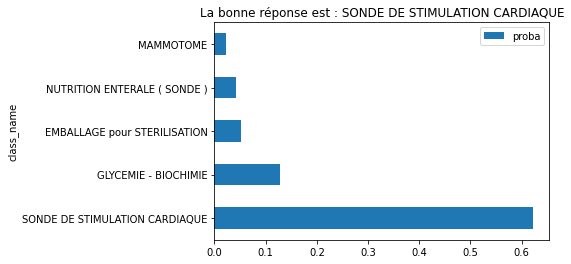

In [14]:
def get_name(x) :
    try :
        return (id_to_dco[id_to_dco['DCO_ID']==int(x)]['LIBELLE'].iloc[0])
    except :
        return("")
    
i = 0
reponse = str(get_name(le.inverse_transform([y_test[i]])))


df_r = pd.DataFrame(pipeline.predict_proba(X_test.loc[i:i+1])).T
df_r["class"] = le.inverse_transform(df_r.index.values)
df_r['class_name'] = df_r['class'].apply(lambda x : get_name(x))
df_r['proba'] = df_r[0]
df_r = df_r.drop(0,axis=1)
df_r = df_r.sort_values('proba',ascending=False)
df_r[:5].plot(kind = 'barh', x = 'class_name',y = 'proba',title = 'La bonne réponse est : '+reponse)

plt.show()

## Autre Test

In [123]:
%%time
#Pipeline
preprocess = ColumnTransformer(
    [('description_tfidf', TfidfVectorizer(sublinear_tf=True, min_df=3,ngram_range=(1, 1),
                                       stop_words=STOP_WORDS,
                                       max_features = 30000,norm = 'l2'), 'DESCRIPTION_INCIDENT'),
     
     ('fab_lib_tfidf', TfidfVectorizer(sublinear_tf=True, min_df=3,ngram_range=(1, 3),
                                       stop_words=STOP_WORDS,
                                       max_features = 20000,norm = 'l2'), 'fab_lib'),
     
    ],
     
     
    remainder='passthrough')


pipeline = Pipeline([
    ('vect', preprocess),
    ('clf', CalibratedClassifierCV(LinearSVC(class_weight='balanced'),cv=3, method='sigmoid')),
])

X = df_train[['DESCRIPTION_INCIDENT','fab_lib']]
y = df_train.DCO_ID


pipeline.fit(X,y)
X_test = df_test[['DESCRIPTION_INCIDENT','fab_lib']]
y_test = df_test.DCO_ID

y_pred = pipeline.predict(X_test)

print("précison:", accuracy_score(y_test,y_pred) )
print("Balanced_accuracy : ", balanced_accuracy_score(y_test,y_pred))

/home/user1/DGS-env/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['qu', 'quelqu'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/home/user1/DGS-env/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['qu', 'quelqu'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


précison: 0.8338082991589629
Balanced_accuracy :  0.6791211404615426
CPU times: user 17min 22s, sys: 24min 33s, total: 41min 56s
Wall time: 5min 53s


In [11]:
%%time
#Pipeline
preprocess = ColumnTransformer(
    [('reference_tfidf', TfidfVectorizer(sublinear_tf=True,
                                         analyzer='word',
                                         min_df=4,
                                         ngram_range=(1, 1),
                                         stop_words=STOP_WORDS,
                                         max_features = 5804,
                                         norm = 'l1'), 'REFERENCE_COMMERCIALE'),
     
     ('libelle_tfidf', TfidfVectorizer(sublinear_tf=True,
                                         analyzer='word',
                                         min_df=1,
                                         ngram_range=(1, 1),
                                         stop_words=STOP_WORDS,
                                         max_features = 8655,
                                         norm = 'l2'), 'LIBELLE_COMMERCIAL'),
     
     ('description_tfidf',TfidfVectorizer(sublinear_tf=True,
                                         min_df=1,
                                         ngram_range=(1, 1),
                                         stop_words=STOP_WORDS,
                                         max_features = 18294,
                                         norm = 'l2'), 'DESCRIPTION_INCIDENT'),
     
    ('fabricant_tfidf',TfidfVectorizer(sublinear_tf=True,
                                         analyzer='char',
                                         min_df=2,
                                         ngram_range=(1, 1),
                                         stop_words=STOP_WORDS,
                                         max_features = 2387,
                                         norm = 'l2'), 'FABRICANT')],
    
    remainder='passthrough')


pipeline = Pipeline([
    ('vect', preprocess),
    ('clf', CalibratedClassifierCV(LinearSVC(class_weight='balanced'),cv=5, method='isotonic')),
])

X = df_train[['DESCRIPTION_INCIDENT','FABRICANT','REFERENCE_COMMERCIALE','LIBELLE_COMMERCIAL']] # 
y = df_train.DCO_ID


pipeline.fit(X,y)
X_test = df_test[['DESCRIPTION_INCIDENT','FABRICANT','REFERENCE_COMMERCIALE','LIBELLE_COMMERCIAL']]
y_test = df_test.DCO_ID

y_pred = pipeline.predict(X_test)

print("précison:", accuracy_score(y_test,y_pred) )
print("Balanced_accuracy : ", balanced_accuracy_score(y_test,y_pred))
print("f1-weighted : ", f1_score(y_test, y_pred, average='weighted'))

précison: 0.8467366372419546
Balanced_accuracy :  0.7248460354275542
f1-weighted :  0.8332177155633408
CPU times: user 6min 41s, sys: 0 ns, total: 6min 41s
Wall time: 6min 41s


In [ ]:
params={'vect__reference_tfidf__analyzer': 'word', 'vect__reference_tfidf__max_features': 5805, 'vect__reference_tfidf__min_df': 4, 'vect__reference_tfidf__norm': 'l1',
        'vect__description_tfidf__max_features': 18294, 'vect__description_tfidf__min_df': 1, 'vect__description_tfidf__norm': 'l2', 
        'vect__fabricant_tfidf__analyzer': 'char', 'vect__fabricant_tfidf__max_features': 2387, 'vect__fabricant_tfidf__min_df': 2, 'vect__fabricant_tfidf__norm': 'l2', 
        'vect__libelle_tfidf__analyzer': 'word', 'vect__libelle_tfidf__max_features': 8655, 'vect__libelle_tfidf__min_df': 1, 'vect__libelle_tfidf__norm': 'l2'}